# Banana Navigation Project

![Screenshot of banana environment](doc/BannerImage.png)

This is an implementation of Deep Reinforcement Q-Learning, applied to train an agent with four possible actions (move left, right, forward, or backward), to pick up yellow bananas and avoid blue bananas.

## Table of Contents
+ Environment Setup
+ Description of Algorithm
  - Value Distribution
  - Parameterized Model
  - Prioritized Replay
+ Implementation of Algorithm
  - Hyperparameters
  - Prioritized Replay Buffer
  - Action Value Distribution Function (Neural Network)
  - Bellman Update (Loss) Computation
  - Training Loop
+ Training
+ Results
+ References

## Environment Setup

+ Follow instructions [here](https://github.com/udacity/Value-based-methods#dependencies) to set up the environment, *with the following changes:*
  - Before running `pip install .`, edit `Value-based-methods/python/requirements.txt` and remove the `torch==0.4.0` line
  - After running `pip install .`, run the appropriate PyTorch installation command for your system indicated [here](https://pytorch.org/get-started/locally/)
  - Continue following the instructions [here](https://github.com/udacity/Value-based-methods#dependencies) to their conclusion.
+ Download the appropriate Unity Environment for your platform:
  - [Linux](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip)
  - [Mac OSX](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana.app.zip)
  - [Windows (32-bit)](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86.zip)
  - [Windows (64-bit)](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86_64.zip)
+ Place the Unity Environment zip file in the `p1_navigation/` folder of the repository cloned in the first step, and unzip the file.

### Imports and references
Run the following code cell at every kernel instance start-up to bring implementation dependencies into the notebook namespace, and identify the path to the simulated environment executable.

In [1]:
from unityagents import UnityEnvironment
from collections import namedtuple, deque
from math import isnan
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

# Set to the path to simulated environment executable on system.
env_location = \
"C:\Projects\Value-based-methods\p1_navigation\Banana_Windows_x86_64\Banana_Windows_x86_64\Banana.exe"

## Description of Algorithm

Deep Reinforcement Q-Learning is a *value-based* class of reinforcement learning algorithms.  These algorithms aim to accurately approximate either the expected reward or reward probability distribution, for every possible pair (state, agent response) in the environment.  With either of these approximations, an agent may be controlled by, when in each state, selecting the action with the highest expected reward.

### Value Distribution
This implementation, like in aims to find the reward probability distribution [1]:<br><br>
$$d_t^{(n)}\equiv(R_t^{(n)}+\gamma_t^{(n)}\textbf{z},\textbf{p}(S_{t+n},a^{*}_{t+n}))$$
<br>
This is an *n-step* value distribution.  The value of the random variable $d_t^{(n)}$ is the sum $R_t^{(n)}$ of the rewards over the next *n* environment time steps, plus the reward distribution $\textbf{z}$ discounted by the factor $\gamma_t^{(n)}$.  The probabilities for the values for the random variable are those that result from, when the agent is in the state $S_{t+n}$, *n* steps advanced from present, the optimal action $a^{*}_{t+n}$ is selected. <br><br>
In practice, the continuous distribution of values is approximated by histogram binning.  The bins are called *atoms* in the literature and typically form an evenly spaced grid between maximum and minimum allowed values $v_{max}$ and $v_{min}$.

### Parameterized Model
As the product of the state and action spaces is very large (infinite, since the state variables are continuous), it is necessary to represent the reward distribution with a parameterized function.  The 'Deep' in Deep Reinforcement Q-Learning implies that the parameterized function is going to be a multi-layer neural network.

Using the notation in [1], let $p_{\theta}^i(s,a)$ denote this function, with set of parameters $\theta$.  Optimization of the parameters in $\theta$ shall be performed, such that, given the selection of an action $a$ by the agent, when the environment is in state $s$, $p_{\theta}^i(s,a)$ approximates the probability that the *n-step* reward will be $z_i$.  As in [1], the available $z_i$ will be defined by:<BR><BR>
$$z_i \equiv v_{min} + (i-1)\frac{v_{max}-v_{min}}{N_{atoms}-1},  i \in {1,...,N_{atoms}}$$
<BR>

The neural network will be a fully connected MLP with one input for each state variable, at least one hidden layer, and one output for each pair $(z_i, a)$.  See the implentation section for details.

### Prioritized Replay
The algorithm will periodically switch between exploration and learning phases.  <br><br>During exploration phases, state transition tuples $(S_t,a_t,r_t,S_{t+1})$ will be collected, transformed to *n-step* transition events via an accumulation buffer, and stored in a prioritized experience buffer. 
<br><br>
During learning phases, transition events sampled from the prioritized experience buffer will be used to optimize the parameterized model.  Like in [1], the probability of utilizing a transition $T$ from the experience buffer is consistent with the proportionality relation: <br><br>
$$p_T \varpropto (Loss)^{\omega}, \omega \in [0,\infty)$$
<br>
The hyperparameter $\omega$ allows tuning of the degree to which the probability of selection is affected by loss magnitude [3].
<br><br>Qualitatively, the $Loss$ in this context is proportional to how inconsistent the parameterized model's prediction is with a prediction that uses actual rewards sampled from the environment.  See the implementation section for detail on how the loss is computed.

## Implementation of Algorithm

### Hyperparameters

#### Environment
`state_dimension`: Dimension of the observable state space<br>
`num_actions`: Number of actions available to agent

In [2]:
class EnvironmentHyperparameters():
    def __init__(self,state_dimension=37,num_actions=4):
        self.state_dimension = state_dimension
        self.num_actions = num_actions

#### Parameterized Model
`num_hidden_layers`: How many hidden layers are included in the neural network model<br>
`hidden_layer_size`: How many neurons are included in each hidden layer<br>
`noise_init`: Initial standard deviation for all noise parameters

In [3]:
class ModelHyperparameters():
    def __init__(self,num_hidden_layers=2,hidden_layer_size=400,noise_init=0.03):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.noise_init = noise_init

#### Reward Distribution
`v_min`: Lower limit clipping value for *n-step* return<br>
`v_max`: Upper limit clipping value for *n-step* return<br>
`gamma`: Discount factor for reward calculation.  An expected reward n steps in the future is discounted by $\gamma^n$<br>
`n_step_order`: How many environment steps from initial state are considered in constructing action value distribution<br>
`n_atoms`: Number of discretization bins for representing possible value distribution returns

In [4]:
class DistributionHyperparameters():
    def __init__(self,v_min=-6,v_max=6,gamma=0.98,n_step_order=25,n_atoms=51):
        self.v_min = v_min
        self.v_max = v_max
        self.gamma = gamma
        self.n_step_order = n_step_order
        self.n_atoms = n_atoms
        self.z_i = \
            torch.tensor([(v_min + (i * ((v_max-v_min) / (n_atoms - 1)))) for i in range(n_atoms)])
        self.z_i = torch.unsqueeze(self.z_i,dim=1)

#### Replay Buffer
`buffer_life`: Buffer will be reset after this many sample() calls<br>
`omega`: Loss influence factor for transition event selection probabilities<br>
`beta`: Importance sampling correction coefficient.  See [3](https://arxiv.org/abs/1511.05952)

In [5]:
class ReplayBufferHyperparameters():
    def __init__(self,buffer_life=9000, omega=0.6, beta=1.0):
        self.buffer_life = buffer_life
        self.omega = omega
        self.beta = beta

#### Optimization Behavior
`lr`: Learning rate for parameterized model optimizer<br>
`learn_interval`: Number of environment exploration steps between each learning phase<br>
`learn_steps`: Number of learning steps (in batches) per learning phase<br>
`batch_size`: Number of n-step transition events to process during each learning phase <br>
`purge_replay`: Boolean, if True, replay buffer will be reset after each learning phase <br>
`target_alpha`: Soft update factor used so that target reward distribution lags policy reward distribution.  See [this explanation](https://deeplizard.com/learn/video/xVkPh9E9GfE) for why this is necessary.  The following update will be applied once per batch:<br><br>
$$\theta_{target} = (1-\alpha)\theta_{target} + \alpha\theta_{policy}$$ <br>


In [6]:
class OptimizationHyperparameters():
    def __init__(self,
                 lr=0.0000125,
                 learn_interval=(5*300),
                 learn_steps=(600),
                 batch_size=16,
                 purge_replay=False,
                 target_alpha=0.25):
        self.lr = lr
        self.learn_interval = learn_interval
        self.learn_steps = learn_steps
        self.batch_size = batch_size
        self.purge_replay = purge_replay
        self.target_alpha = target_alpha

### Prioritized Replay Buffer

Like in [3](https://arxiv.org/abs/1511.05952), a sum tree structure is used for efficient weighted sampling over a large number of items.  This implementation is heavily based on that in reference [4](http://www.sefidian.com/2022/09/09/sumtree-data-structure-for-prioritized-experience-replay-per-explained-with-python-code/), but with some organizational changes to accomodate dynamic resizing.

In [7]:
# Object that represents an experience in the experience buffer and/or a non-leaf node of the sum tree
# Experience tuples are stored in the self.data attribute
class SumTreeNode():
    
    def __init__(self,data=None,p_i=0):
        self.data = data
        self.p_i = p_i
        self.parent = None
        self.left_child = None
        self.right_child = None
    
    def update_p(self, delta_p):
        self.p_i += delta_p
        if self.parent is not None:
            self.parent.update_p(delta_p)
    
    def attach_child(self,child):
        if self.data is None:    # Not a leaf node
            if self.left_child is None:    # No children, become leaf with cloned data
                self.data = child.data
                self.update_p(child.p_i - self.p_i)
            else:    # Non-leaf node, attach to lower p_i side
                if self.left_child.p_i < self.right_child.p_i:
                    delegate_node = self.left_child
                else:
                    delegate_node = self.right_child
                delegate_node.attach_child(child)
        else:    # self is a leaf-node.  Clone self.data into new child, become non-leaf
            self.left_child = SumTreeNode(self.data,self.p_i)
            self.data = None
            self.right_child = child
            self.left_child.parent, self.right_child.parent = self, self     
            self.update_p((self.left_child.p_i + self.right_child.p_i)- self.p_i)
    
    def remove(self):
        if self.parent is not None:  # remove only has effect if there is a parent
            if self.parent.left_child is self:
                sibling = self.parent.right_child
            else:
                sibling = self.parent.left_child
            # Clone data to parent from sibling and update references
            if sibling is None:
                print(f'Removing:{self.data} |||| {self.p_i}')
                print(f'Parent:{self.parent.data} |||| {self.parent.p_i}')
                print(f'Sibling:{sibling.data} |||| {sibling.p_i}')
            self.parent.data = sibling.data
            self.parent.left_child = sibling.left_child
            self.parent.right_child = sibling.right_child
            if (self.parent.left_child is not None):
                self.parent.left_child.parent = self.parent
            if (self.parent.right_child is not None):
                self.parent.right_child.parent = self.parent
            self.parent.update_p(sibling.p_i - self.parent.p_i)
    
    def weighted_retrieve(self,p_samp):
        if self.data is not None: # must be a leaf-node
            return self
        else:
            if self.left_child.p_i >= p_samp:
                return self.left_child.weighted_retrieve(p_samp)
            else:
                return self.right_child.weighted_retrieve(p_samp - self.left_child.p_i)
            
    # This is used to identify low sampling probability nodes for removal
    def minimal_node(self):
        if self.data is not None:
            return self
        else:
            min_left = self.left_child.minimal_node()
            min_right = self.right_child.minimal_node()
            return min_left if min_left.p_i < min_right.p_i else min_right  
    
    # String representation of tree
    def tree_str(self,lvl=0):
        lvl_str= '--> '*lvl
        left_str = self.left_child.tree_str(lvl+1) if self.left_child is not None else ''
        right_str = self.right_child.tree_str(lvl+1) if self.left_child is not None else ''
        par_str = self.parent.p_i if self.parent is not None else 'nothing'
        my_str = f'{lvl_str}[{self.data}|{self.p_i}] under [{par_str}]\n'
        return f'{my_str}{left_str}{right_str}'

In [8]:
# Prioritized replay buffer definition

# Experience aggregate
Experience = namedtuple('Experience',['state','action','reward','last_state'])

class PrioritizedReplayBuffer():
    
    def __init__(self,replay_buffer_hyperparameters=ReplayBufferHyperparameters()):
        self.buffer_life = replay_buffer_hyperparameters.buffer_life
        self.omega = replay_buffer_hyperparameters.omega
        self.store = SumTreeNode()
        self.sample_count = 0
        self.exp_count = 0
        self.beta = replay_buffer_hyperparameters.beta
    
    def __len__(self):
        return self.exp_count
    
    def add_experience(self, experience, loss):
        new_p_i = pow(loss, self.omega)
        self.store.attach_child(SumTreeNode(experience, new_p_i))
        self.exp_count += 1
            
    def sample(self,batch_size):
        sample_keys = (np.random.rand(batch_size)*self.store.p_i).tolist()
        samples = ([self.store.weighted_retrieve(p_samp) for p_samp in sample_keys],
                   (self.exp_count,self.beta,self.store.p_i))
        self.sample_count += 1
        if (self.sample_count >= self.buffer_life):
            self.sample_count = 0
            self.store = SumTreeNode()
            self.exp_count = 0
            print ('Flushed replay buffer!')
        return samples

In [9]:
# Unit test for PrioritizedReplayBuffer
test_rep_hyp = ReplayBufferHyperparameters(buffer_life = 2000, omega = 1)
test_rep_buffer = PrioritizedReplayBuffer(test_rep_hyp)
test_experiences = ['one','two','three','four','five','six','seven','eight','nine']
test_weights = [0.99,2,3,1,2,3,1,2,3]
test_batch_size = 4
test_batches = 1000
for (e,wt) in zip(test_experiences,test_weights):
    test_rep_buffer.add_experience(e,wt)
test_samples = []
for i in range(test_batches):
    test_samples += [sample.data for sample in test_rep_buffer.sample(test_batch_size)[0]]
print("Normalized Counts")
for exp in test_experiences:
    print(f'{exp}: {test_samples.count(exp) / test_samples.count("four")}')


Normalized Counts
one: 0.9414225941422594
two: 1.7656903765690377
three: 2.702928870292887
four: 1.0
five: 1.8828451882845187
six: 2.912133891213389
seven: 0.9205020920502092
eight: 1.8284518828451883
nine: 2.782426778242678


In [10]:
# Diagnostic function
def tensor_check(input,desc):
    if torch.any(torch.isnan(input)):
        print(f'NaNs in {desc}:')
        print(input)
    if torch.any(torch.isinf(input)):
        print(f'Inf in {desc}:')
        print(input)

In [11]:
# tensor_check unit test
A = torch.tensor([3,0,1])
B = torch.tensor([2,0,1])
C = torch.tensor([1,1,1])
tensor_check(torch.div(A,B),"A/B")
tensor_check(torch.div(C,B),"C/B")

NaNs in A/B:
tensor([1.5000,    nan, 1.0000])
Inf in C/B:
tensor([0.5000,    inf, 1.0000])


### Action Value Distribution Function (Neural Network)

The linear layers have noisy bias and weight components, implemented with factored gaussian noise according to [5](https://arxiv.org/abs/1706.10295).  The standard deviation of each noise component is subject to optimization (learning) by the optimizer.

In [12]:
class NoisyLinear(nn.Module):
    def __init__(self,in_dim,out_dim,noise_init=0.05):
        super(NoisyLinear,self).__init__()
        self.deterministic_linear = nn.Linear(in_dim,out_dim)
        self.noisy_weights = \
            nn.Parameter(noise_init*torch.ones(in_dim,out_dim,dtype=torch.float32))
        self.noisy_bias = nn.Parameter(noise_init*torch.ones(1,out_dim,dtype=torch.float32))
    
    def noise_transform(self,x):
        # See section 3(b) of reference [5]
        tensor_check(x,'Input to noise_transform')
        x = torch.mul(torch.sgn(x),torch.sqrt(torch.abs(x)))
        tensor_check(x,'Output of noise_transform')
        return x
    
    def forward(self,x):
        # Generate factorized gaussian noise, clamping to +/- 5 sigma
        in_dim_noise = \
            self.noise_transform( \
                torch.clamp( \
                    torch.randn((self.noisy_weights.size(dim=0),1),device=x.device),-5.0,5.0))
        out_dim_noise = \
            self.noise_transform( \
                torch.clamp( \
                    torch.randn((1,self.noisy_weights.size(dim=1)),device=x.device),-5.0,5.0))
        
        weight_noise = torch.mul(self.noisy_weights,torch.matmul(in_dim_noise,out_dim_noise))
        bias_noise = torch.mul(self.noisy_bias,out_dim_noise)
    
        x = x.float()
        return self.deterministic_linear(x) + torch.matmul(x,weight_noise) + bias_noise

In [13]:
# Unit test for NoisyLinear
test_noisy_layer = NoisyLinear(10,4)
test_input_data = torch.ones((5,10))
test_output = test_noisy_layer(test_input_data)
print(f'Input size:{test_input_data.size()}')
print(f'Output size:{test_output.size()}')

Input size:torch.Size([5, 10])
Output size:torch.Size([5, 4])


In [14]:
# Parameterized Model Implementation
class ParameterizedModel(nn.Module):
    def __init__(self, 
                 environment_hyperparameters = EnvironmentHyperparameters(),
                 model_hyperparameters = ModelHyperparameters(),
                 distribution_hyperparameters = DistributionHyperparameters()
                ):
        super(ParameterizedModel,self).__init__()
        in_dim = environment_hyperparameters.state_dimension
        out_dim = environment_hyperparameters.num_actions \
                  * distribution_hyperparameters.n_atoms
        hidden_size = model_hyperparameters.hidden_layer_size
        num_hidden_layers = model_hyperparameters.num_hidden_layers
        noise_init = model_hyperparameters.noise_init
        
        self.distribution_hyperparameters = distribution_hyperparameters
        self.environment_hyperparameters = environment_hyperparameters
        self.model_hyperparameters = model_hyperparameters
        self.num_actions = environment_hyperparameters.num_actions
        self.n_atoms = distribution_hyperparameters.n_atoms
        
        layers = []
        layers.append(NoisyLinear(in_dim,hidden_size,noise_init))
        layers.append(nn.LeakyReLU(negative_slope=0.05))
        for i in range(num_hidden_layers-1):
            layers.append(NoisyLinear(hidden_size,hidden_size,noise_init))
            layers.append(nn.LeakyReLU(negative_slope=0.05))
        layers.append(NoisyLinear(hidden_size,out_dim,noise_init))
        
        self.reg_layers = nn.Sequential(*layers)
        
    def forward(self,x):
        x = self.reg_layers(x)
        
        # See reference [1], softmax must be calculated individually on the
        # atoms for each action since each action is a probability distribution
        y = torch.tensor([],requires_grad=True,device=x.device)
        for i in range(self.num_actions):
            y = torch.hstack((y,F.softmax(x[:,(i*self.n_atoms):((i+1)*self.n_atoms)],dim=1)))
        return y

In [15]:
# Unit test for ParameterizedModel
test_env_hyp = EnvironmentHyperparameters(11,3)
test_mdl_hyp = ModelHyperparameters(3,30)
test_dst_hyp = DistributionHyperparameters(n_atoms = 7)
test_mdl = ParameterizedModel(test_env_hyp, test_mdl_hyp, test_dst_hyp)
test_input_data = torch.randn(5,11)
test_output = test_mdl(test_input_data)
print(f'Input size:{test_input_data.size()}')
print(f'Output size:{test_output.size()}')

Input size:torch.Size([5, 11])
Output size:torch.Size([5, 21])


### Bellman Update (Loss) Computation

See algorithm 1 in reference [2](https://arxiv.org/abs/1707.06887).  Instead of cross-entropy loss on the last line, instead the computed loss is the KL divergence between the current distribution and the target distribution, as in [1](https://arxiv.org/abs/1710.02298).

In [16]:
def Bellman_Update(policy_net, target_net, experiences, device):
    
    distribution_hyperparameters = policy_net.distribution_hyperparameters
    
    # Convert experiences to tensors, short alias 
    # hyperparameters since somewhat intense here
    init_states = torch.tensor(np.array([e.data.state for e in experiences[0]])).to(device)
    actions = torch.tensor([e.data.action for e in experiences[0]]).to(device)
    rewards = torch.tensor([e.data.reward for e in experiences[0]]).unsqueeze(dim=1).to(device)
    final_states = torch.tensor(np.array([e.data.last_state for e in experiences[0]])).to(device)
    
    p_i_total = experiences[1][2]
    # Normalized p_i see eqn (1) of reference [3]
    p_i = torch.tensor([(e.p_i/p_i_total) for e in experiences[0]]).to(device) 
    
    buf_N = torch.tensor(experiences[1][0]).to(device)
    beta = torch.tensor(experiences[1][1]).to(device)
    gamma = torch.tensor([distribution_hyperparameters.gamma]).to(device)
    n_step_order = torch.tensor([distribution_hyperparameters.n_step_order]).to(device)
    v_min = torch.tensor([distribution_hyperparameters.v_min]).to(device)
    v_max = torch.tensor([distribution_hyperparameters.v_max]).to(device)
    z_i = distribution_hyperparameters.z_i.to(device)
    n_atoms = policy_net.n_atoms
    delta_z = (v_max - v_min) / (n_atoms - 1)
    num_exp = len(init_states)
    num_act = policy_net.num_actions
    
    # Input checks
    tensor_check(p_i,'p_i')
    
    # Get d_t
    d_t_all_actions = policy_net(init_states)
    tensor_check(d_t_all_actions,'d_t_all_actions')
    d_t = torch.empty((0,n_atoms),requires_grad=True).to(device)
    for i in range(num_exp):
        d_t = torch.vstack((d_t,d_t_all_actions[i,(actions[i]*n_atoms):((actions[i]+1)*n_atoms)]))
    tensor_check(d_t,'d_t')
    
    # Get d_t_prime
    d_t_prime_all_actions = target_net(final_states)
    mean_action_values = torch.empty((num_exp,0),requires_grad=True).to(device)
    for i in range(num_act):
        mean_action_values = \
            torch.hstack((mean_action_values,
                torch.matmul(d_t_prime_all_actions[:,(i*n_atoms):((i+1)*n_atoms)],z_i)))
    targ_act = torch.argmax(mean_action_values,dim=1)
    d_t_prime = torch.empty((0,n_atoms),requires_grad=True).to(device)
    for i in range(num_exp):
        d_t_prime = torch.vstack( \
            (d_t_prime,
             d_t_prime_all_actions[i,(targ_act[i]*n_atoms):((targ_act[i]+1)*n_atoms)]))
    tensor_check(d_t_prime,'d_t_prime')
        
    # Compute target distribution m_i.  See algorithm 1 of reference [2]
    m_i = torch.zeros((num_exp,n_atoms)).to(device)
    disc = torch.pow(gamma,n_step_order).to(device)
    Tz_j = torch.clamp(torch.add(rewards,torch.mul(disc,d_t_prime)), v_min, v_max)
    b_j = torch.div(torch.sub(Tz_j,v_min),delta_z)
    l_bins = torch.floor(b_j).long()
    u_bins = torch.ceil(b_j).long()
    tensor_check(Tz_j,'Tz_j')
    tensor_check(b_j,'b_j')
    for j in range(n_atoms):
        test_rslt = torch.sub(u_bins[:,j],b_j[:,j])
        m_i[torch.arange(num_exp).long(),l_bins[:,j]] = \
            torch.add(m_i[torch.arange(num_exp).long(),l_bins[:,j]],
                      torch.mul(d_t_prime[:,j],torch.sub(u_bins[:,j],b_j[:,j])))
        m_i[torch.arange(num_exp).long(),u_bins[:,j]] = \
            torch.add(m_i[torch.arange(num_exp).long(),u_bins[:,j]],
                      torch.mul(d_t_prime[:,j],torch.sub(b_j[:,j],l_bins[:,j])))
    
    # Compute KL divergence between distributions for each experience
    # Return loss for all experiences in batch.  We do not reduce to mean
    # because the individual losses are needed to update the prioritized
    # experience replay buffer.
    biased_loss = F.kl_div(d_t.log(),m_i,reduction='none')
    tensor_check(biased_loss,'biased_loss')
    
    # Multiply losses by importance sampling weights to correct for distribution change
    # with prioritized sampling.  Clamp p_i because reciprocal function is scary
    p_i = torch.clamp(p_i,min=1e-9)
    w_i = torch.pow( \
            torch.reciprocal( \
              torch.mul(buf_N,p_i)),beta).unsqueeze(dim=1)
    w_i = torch.clamp(w_i,1e-8,1.0)
    tensor_check(w_i,'w_i')
    return (torch.mul(w_i,biased_loss).clamp(min=0), w_i)

### Training Loop

#### Training Session Options
`max_episodes`: Maximum number of episodes before stopping training run<br>
`rewards_buffer`: Pass in empty list or existing list.  Average rewards per episode data is appended to this list<br>
`reward_window`: Length of averaging window for reporting rewards, in number of episodes<br>
`report_interval`: Interval in episodes for updating `rewards_buffer` and displaying status<br>
`solved_threshold`: Average reward over averaging window required to stop training early<br>

In [17]:
# Logger for the episodic scores and running average
class PerformanceLogger():
    def __init__(self,avg_window_size=100,starting_scores=None):
        self.avg_window_size = avg_window_size
        self.scores = starting_scores if starting_scores is not None else []
        self.internal_run_avg = 0
        
    def add_score(self,score):
        self.scores.append(score)
        self.internal_run_avg += score / self.avg_window_size
        # Remove tail of running average
        if len(self.scores) > self.avg_window_size:
            self.internal_run_avg -= self.scores[-(self.avg_window_size + 1)] / self.avg_window_size
            
    def run_avg(self):
        if len(self.scores) < self.avg_window_size:
            return None
        else:
            return self.internal_run_avg

In [18]:
# Unit test PerformanceLogger
test_perf_log = PerformanceLogger()
for i in range(100):
    test_perf_log.add_score(i)
print(f'First average: {test_perf_log.run_avg()}')
for i in range(100,200):
    test_perf_log.add_score(i)
print(f'Second average: {test_perf_log.run_avg()}')

First average: 49.5
Second average: 149.5


In [19]:
class TrainingOptions():
    def __init__(self,max_episodes=2000,
                 rewards_buffer=[],reward_window=100,
                 report_interval=5,solved_threshold=13):
        self.max_episodes = max_episodes
        self.rewards_buffer = rewards_buffer
        self.report_interval = report_interval
        self.solved_threshold = solved_threshold
        self.performance_logger = PerformanceLogger(reward_window)

In [20]:
# Circular buffer for the n-step rewards.  
# Could be more efficient but n is only 3 
# in methods of rainbow dqn paper and it worked
# out for them.
class MultistepBuffer():
    def __init__(self,n_step_order,gamma=1.0):
        self.n_step_order = n_step_order
        self.store = deque(maxlen = n_step_order + 1)
        self.gamma = gamma
    
    def add_experience(self,exp):
        self.store.append(exp)
    
    def ready(self):
        return len(self.store) == (self.n_step_order + 1)
    
    def get_n_step_experience(self):
        out_state = self.store[0].state
        out_action = self.store[0].action
        out_reward = \
            sum([((self.store[i].reward) * pow(self.gamma,i)) for i in range(self.n_step_order)])
        out_final_state = self.store[-1].state
        return SumTreeNode(Experience(out_state, out_action, out_reward, out_final_state),p_i=1)

In [21]:
# This function is copied from the Lunar Lander dqn_agent.py file.
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target

    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [22]:
# Selects action number that has the highest expected return
def sel_action(policy_net, state, device):
    z_i = policy_net.distribution_hyperparameters.z_i.to(device)
    num_act = policy_net.environment_hyperparameters.num_actions
    n_atoms = policy_net.distribution_hyperparameters.n_atoms
    
    d_t = policy_net(torch.tensor(state).unsqueeze(dim=0).to(device))
    mean_action_values = torch.tensor([],requires_grad=False).to(device)
    for i in range(num_act):
        mean_action_values = torch.hstack( \
                                (mean_action_values,
                                 torch.matmul(d_t[0,(i*n_atoms):((i+1)*n_atoms)],z_i)))
    return torch.argmax(mean_action_values)

#### `train_net` Parameters
`net`: Parameterized model to use for training run<br>
`replay_buffer`: Replay buffer object to use for training run<br>
`optimization_hyperparameters`: `OptimizationHyperparameters` object to use for training run<br>
`train_options`: `TrainingOptions` object to use for training run

#### `train_net` Returns
Reference to the `PerformanceLogger` of the supplied `train_options`

In [23]:
def train_net(policy_net, 
              env,
              opt_hyp=OptimizationHyperparameters(),
              replay_buffer=PrioritizedReplayBuffer(),
              train_options=TrainingOptions(),
              ):
    
    # Use gpu if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Move model to device
    policy_net = policy_net.to(device)
    
    # Aliases for readability only
    perf_log = train_options.performance_logger
    max_eps = train_options.max_episodes
    n_step_order = policy_net.distribution_hyperparameters.n_step_order
    gamma = policy_net.distribution_hyperparameters.gamma
    omega = replay_buffer.omega
    batch_size = opt_hyp.batch_size
    learn_steps = opt_hyp.learn_steps
    purge_replay = opt_hyp.purge_replay
    
    # Setup optimizer
    optimizer = Adam(policy_net.parameters(), lr=opt_hyp.lr, weight_decay=5e-5, eps = 1.5e-4)
    
    # Generate target network
    target_net = ParameterizedModel(policy_net.environment_hyperparameters,
                                    policy_net.model_hyperparameters,
                                    policy_net.distribution_hyperparameters).to(device)
    
    # Set initial parameters of target network to zero to avoid initial noise
    for param in target_net.parameters():
        param.data.fill_(0)
    
    # Counters
    learn_cntr = 0
    rpt_cntr = 0
    
    # Get brain info for environment.  That is the term
    # Unity ML-Agents for controllers of agents in
    # simulation
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    
    for episode in range(max_eps):
        
        n_step_buf = MultistepBuffer(n_step_order, gamma)
        env_info = env.reset(train_mode=False)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        done = False
        
        while done == False:
            
            # Environment interaction
            action = sel_action(policy_net, state, device)
            env_info = env.step(int(action.cpu()))[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            # Process interaction results
            score += reward
            if not (reward == 0):
                print(f'Episode {episode+1}: score = {score}', end='\r')
            n_step_buf.add_experience(Experience(state,action,reward,None))
            
            # If the multi-step buffer has enough experiences to make
            # a full sequence, get the sequence, compute the loss on
            # the sequence, add the experience with loss to the replay
            # buffer
            if n_step_buf.ready():
                n_step_exp = n_step_buf.get_n_step_experience()
                loss, w_i = Bellman_Update(policy_net, target_net, ([n_step_exp],(1,1,1)), device)
                n_step_p_i = loss[0].sum().pow(omega)
                tensor_check(n_step_p_i,'n_step_p_i')
                replay_buffer.add_experience(n_step_exp.data,n_step_p_i.item())
                
            state = next_state
            
            learn_cntr += 1
            if (learn_cntr % opt_hyp.learn_interval) == 0:
                learn_cntr = 0
                if len(replay_buffer) >= batch_size:
                    opt_perf_log = PerformanceLogger()
                    for l_step in range(learn_steps):
                        
                        # Check that a sample op did not trigger reset
                        if len(replay_buffer) < batch_size:
                            break
                        samp_exp = replay_buffer.sample(batch_size)
                    
                        # Zero gradients, get Bellman_Update loss, take mean, accumulate
                        # gradients backward and step optimizer.
                        optimizer.zero_grad()
                        loss_vec, w_i = \
                            Bellman_Update(policy_net, target_net, samp_exp, device)
                        loss_vec = loss_vec.sum(dim=1)
                        loss_avg = torch.div(torch.sum(loss_vec), batch_size)
                        loss_avg.backward()
                        optimizer.step()
                        opt_perf_log.add_score(loss_avg.item())
                        
                        # Update priorities in replay buffer according to losses
                        new_p_i = torch.div(loss_vec,w_i.squeeze(dim=1)).pow(omega)
                        tensor_check(new_p_i,'new_p_i')
                        for exp_num in range(batch_size):
                                samp_exp[0][exp_num].update_p( \
                                    (new_p_i[exp_num] - samp_exp[0][exp_num].p_i).item())
                    
                        # Output status of optimization periodically
                        if ((l_step + 1) % (learn_steps / 10) == 0):
                            opt_avg = opt_perf_log.run_avg()
                            if len(opt_perf_log.scores) < opt_perf_log.avg_window_size:
                                opt_avg = sum(opt_perf_log.scores) / len(opt_perf_log.scores)
                            print(f'Completed {l_step + 1} of {learn_steps} learning steps.  Loss = {opt_avg:.5f})', end='\r')
                    
                    print('\n')
                    
                    # Soft update target network with policy network
                    soft_update(policy_net, target_net, opt_hyp.target_alpha)
                    
                    if purge_replay:
                        buf_params = ReplayBufferHyperparameters(replay_buffer.buffer_life,
                                                                 replay_buffer.omega,
                                                                 replay_buffer.beta)
                        replay_buffer = PrioritizedReplayBuffer(buf_params)
                    
        perf_log.add_score(score)
        
        rpt_cntr += 1
        if (rpt_cntr % train_options.report_interval) == 0:
            rpt_cntr = 0
            report = f'Completed {episode + 1} episodes. Average score = '
            avg_score = perf_log.run_avg()
            if len(perf_log.scores) < perf_log.avg_window_size:
                avg_score = sum(perf_log.scores) / len(perf_log.scores)
            print(f'{report}{avg_score:.2f}')
        
        if ((episode >= 99) and (perf_log.run_avg() >= train_options.solved_threshold)):
            print(f'Solved with average score of {perf_log.run_avg()} in {episode+1} episodes')
            break    
        
        if episode == (max_eps - 1):
            print(f'Failed to solve within the maximum of {max_eps} episodes')
            break
            
    return perf_log

## Training

In [24]:
model = ParameterizedModel()
env = UnityEnvironment(file_name=env_location)
rslt = train_net(model,env)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Completed 600 of 600 learning steps.  Loss = 1.94575)

Completed 5 episodes. Average score = -1.20
Completed 600 of 600 learning steps.  Loss = 0.84376)

Completed 10 episodes. Average score = -0.60
Completed 600 of 600 learning steps.  Loss = 0.56986)

Completed 15 episodes. Average score = -0.33
Completed 600 of 600 learning steps.  Loss = 0.62529)

Completed 20 episodes. Average score = -0.15
Completed 600 of 600 learning steps.  Loss = 0.71568)

Completed 25 episodes. Average score = -0.24
Completed 600 of 600 learning steps.  Loss = 0.73778)

Completed 30 episodes. Average score = -0.03
Completed 600 of 600 learning steps.  Loss = 0.72220)

Completed 35 episodes. Average score = -0.11
Completed 600 of 600 learning steps.  Loss = 0.71832)

Completed 40 episodes. Average score = -0.07
Completed 600 of 600 learning steps.  Loss = 0.72046)

Completed 45 episodes. Average score = 0.00
Completed 600 of 600 learning steps.  Loss = 0.66916)

Completed 50 episodes. Average score = -0.06
Co

Completed 600 of 600 learning steps.  Loss = 1.00574)

Completed 795 episodes. Average score = 13.07
Solved with average score of 13.070000000000014 in 795 episodes


In [25]:
# Save final model
torch.save(model,"end_training_one.pt")

## Results

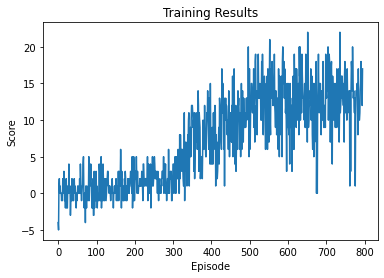

In [26]:
import matplotlib.pyplot as plt
plt.plot(rslt.scores)
plt.title('Training Results')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

### Demo
The cell below can be run to demonstrate the behavior of the trained agent.  It is necessary to first run all cells except the training cell.  One can also review this [video](https://youtu.be/ieCMukh9Rwg) of the trained agent's behavior.

In [24]:
demo_eps = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
demo_net = torch.load('submission_net.pt')
demo_net = demo_net.to(device)
env = UnityEnvironment(file_name=env_location)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
for episode in range(demo_eps):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    done = False
    while done == False:
            
            # Environment interaction
            action = sel_action(demo_net, state, device)
            env_info = env.step(int(action.cpu()))[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            # Process interaction results
            score += reward
            if not (reward == 0):
                print(f'Episode {episode+1}: score = {score}', end='\r')
                
            state = next_state

env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Discussion

The `n_step_order` hyperparameter strongly influenced the outcome.  If too low, the signals from anything except a banana immediately in front of the agent appeared to get washed together, preventing effective learning of even short range behavior.  If `n_step_order` were too high, a similar state value washout seemed to happen at longer distances.  With high `n_step_order` there also tended to be very quick learning, getting near solve performance after about 100 episodes, but then progressive and continuous decline, after briefly peaking.  Care has to be taken that experiences in the replay buffer do not become too 'stale' with higher order, since the direct reward terms are those observed at a particular time, but the policy is continuously changing.<br>

The score is not necessarily the best metric to assess the progress of training.  Probably on many runs before success, the process was terminated too early, since the score did not seem to be improving.  However, close evaluation of the agent's behavior typically demonstrates progressive addressing of the issues with 'short-cut' solutions.  For example, it was common early in training that blue bananas would be hit a few times in random forward moves, resulting in the agent only backing up.  It can take a lot episodes for the sparse signal, that going backwards all the time can have a similar result, to effect appropriate forward vs. backward balance.  Once the basic balance problems were resolved, scores increased very quickly.  They then slowly leveled off as behavior in more infrequently occurring situations was addressed.

### Ideas for Future Work
+ Delay-line memory / state augmentation: A common pitfall encountered in the agent policy, after some initial progress, was that the agent would sometimes turn around in a circle without stopping, until the end of an episode.  This was evidently because no direction away from its position looked safe, so it would keep turning in search of a safe direction to travel.  A lot of environment time seemed to be wasted in redundant experiences, since there is little additional information being supplied after the first full look-around.  It seems that concatenating some state history, perhaps the last 5 or 6 sets of state observables, as well as the selected actions, onto the input to the parameterized function could improve the situation.  This measure would make it possible for the agent to, in principle, detect when it has done a full revolution without moving anywhere, and possibly learn to take a less safe looking forward move in such a situation.
+ Performance based noise scheduling: The initial noise magnitude was a parameter that needed to be updated in response to many other hyperparameter changes, in order for learning to be possible at all.  Too little initial noise, and the agent would become locked in some simple initial behavior.  But if there is too much initial noise, improvement can take a very long time.  This is because the noise magnitudes are a trainable parameters, and training updates will not lower these amplitudes until the network starts achieving performance beyond random-policy.  It seems sensible to implement a schedule, in which the noise amplitudes are globally reduced from a starting value, until some minor performance of the agent is evident.  Following this, the normal learnable noise magnitude parameter mechanism can take over.  The noise might also be globally increased when the performance trajectory suggests overfitting (peaking and subsequent decline in performance).
+ Ensemble learning: A very common phenomenon was that an agent would learn to favor turning one way or the other (left/right) and eventually never turn in the non-dominant direction, even when it was possible to save time doing so.  At least one agent learned a work around after learning to only ever turn left.  When this agent detected a yellow banana passing on the right, it would go past it, turn left, and then back up to get it.  It is possible this inefficient habituation might be addressed by training multiple networks at the same time on the experience data, and setting up some kinda of competitive feedback.  Perhaps each network in the ensemble would get to operate the agent for a whole episode in round-robin fashion, then the other networks would be directly trained on the full output of the 'operator' network, according to its field performance.

## References
[1] Hessel et. al., Rainbow: Combining Improvements in Deep Reinforcement Learning, arXiv:1710.02298 <br>
[2] Bellemare et. al., A Distributional Perspective on Reinforcement Learning, arXiv:1707.06887 <br>
[3] Schaul et. al., Prioritized Experience Replay, arXiv:1511.05952<br>
[4] http://www.sefidian.com/2022/09/09/sumtree-data-structure-for-prioritized-experience-replay-per-explained-with-python-code/<br>
[5] Fortunato et. al., Noisy Networks for Exploration, arXiv:1706.10295